<a href="https://colab.research.google.com/github/elianaostro/Graficos/blob/main/Analisis_Laboratorio_Pendulo_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datos

Inventamos acá un dataset sintético para posibles datos del péndulo.

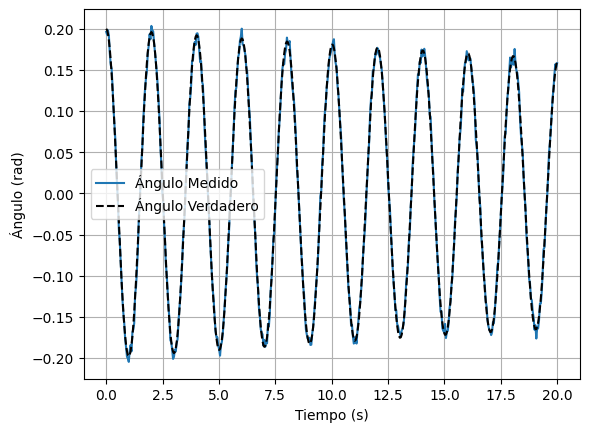

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
theta_0 = 0.2  # Ángulo inicial en radianes (aproximadamente 11.5 grados)
beta = 0.01    # Coeficiente de amortiguamiento
omega_d = np.sqrt(9.81/1)  # Frecuencia angular amortiguada para un péndulo de 1m de longitud
delta = 0.0    # Ángulo de fase

# Datos sintéticos
t = np.linspace(0, 20, 500)  # Generar datos de tiempo de 0 a 20 segundos
theta_t = theta_0 * np.exp(-beta * t) * np.cos(omega_d * t + delta)

# Ruido para simular mediciones reales
ruido = np.random.normal(0, 0.005, t.shape)
theta_con_ruido = theta_t + ruido

# Gráfico
plt.plot(t, theta_con_ruido, label='Ángulo Medido')
plt.plot(t, theta_t, 'k--', label='Ángulo Verdadero')
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.legend()
plt.show()


# Calculamos el período de tres maneras

## Transformada de Fourier (gracias Claus!)

Perídoo estimado 2.00


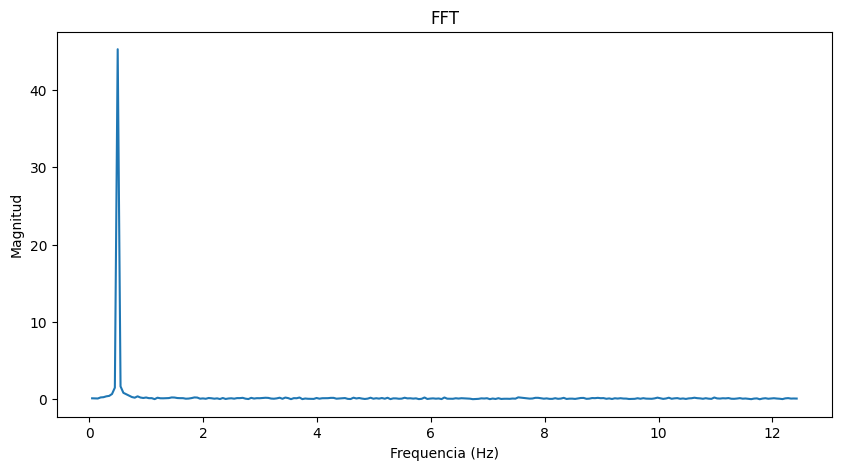

In [ ]:
from numpy.fft import fft, fftfreq

# FFT
yf = fft(theta_con_ruido)
xf = fftfreq(len(t), t[1] - t[0])

# Excluyo la frecuencia cero y obteng0 la frecuencia con la magnitud máxima
dominant_frequency = xf[1:][np.argmax(np.abs(yf[1:]))]

# Frecuencia a período
estimated_period = 1 / dominant_frequency

print(f"Perídoo estimado {estimated_period:.2f}")

# Plot de las frecuencias positivas
plt.figure(figsize=(10, 5))
plt.plot(xf[1:int(len(xf)/2)], np.abs(yf[1:int(len(yf)/2)]))
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Magnitud')
plt.title('FFT')
plt.show()

## Con un ajuste

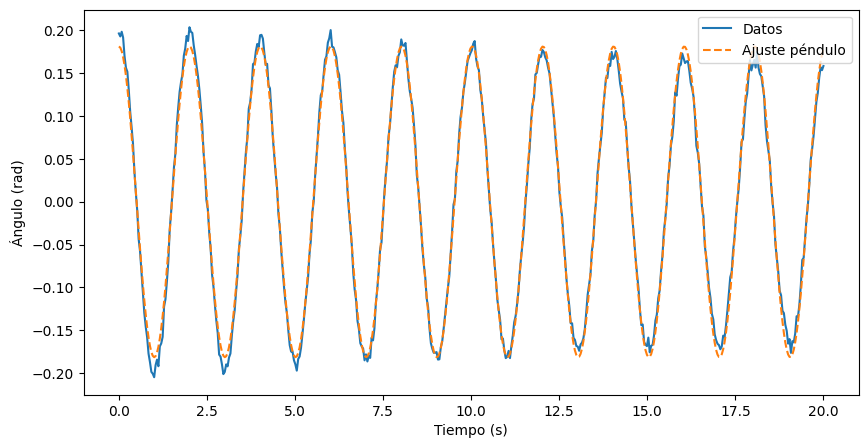

Perído calculado 3.1 s


In [ ]:
from scipy.optimize import curve_fit

def sine(t, A, omega, phi, B):
    return A * np.sin(omega * t + phi) + B

# Estimaciones iniciales (puedes ajustar estos valores según tu observación de la señal)
A_init = np.max(theta_con_ruido)
omega_init = 2 * np.pi / 2  # usando 2 segundos como periodo inicial estimado
phi_init = 0
B_init = np.mean(theta_con_ruido)

p0 = [A_init, omega_init, phi_init, B_init]

# Ajustar la función a los datos
params, params_covariance = curve_fit(sine, t, theta_con_ruido, p0=p0, maxfev=5000)
A, omega, phi, B = params

# Graficar los datos originales y el ajuste
plt.figure(figsize=(10, 5))
plt.plot(t, theta_con_ruido, label='Datos')
plt.plot(t, sine(t, *params), '--', label='Ajuste péndulo')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.show()

print("Perído calculado", f'{omega:.1f}', "s")

## Con máximos

El perídoo es 2.0 +/- 0.1


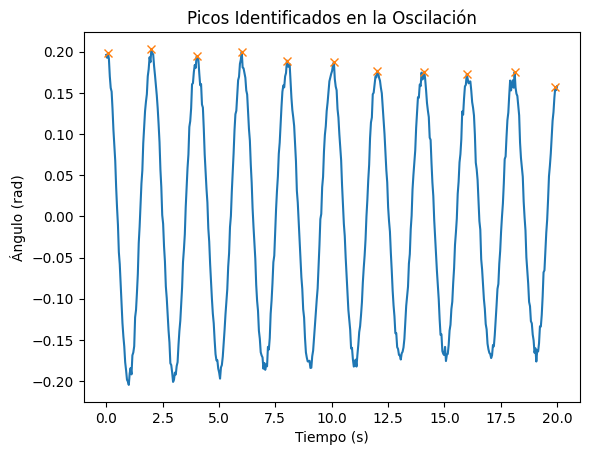

In [ ]:
from scipy.signal import find_peaks

# Encontrar picos positivos
picos, _ = find_peaks(theta_con_ruido, distance=omega*2, height=0.15)

# Extraer alturas de los picos
alturas_picos = theta_con_ruido[picos]

# Calcular el período de la oscilación
periodos = np.diff(t[picos])

print(f"El período es {np.mean(periodos):.1f} +/- {np.std(periodos):.1f}")

# Gráfica de Picos
plt.plot(t, theta_con_ruido)
plt.plot(t[picos], alturas_picos, "x")
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.title('Picos Identificados en la Oscilación')
plt.show()

# Estimación de la gravedad usando el período


La fórmula que describe el período $T$ de un péndulo simple (sin amortiguamiento y con ángulos pequeños) está dada por:

\begin{equation}
T = 2\pi \sqrt{\frac{l}{g}}
\end{equation}

donde:
- $T$ es el período de oscilación.
- $l$ es la longitud del péndulo.
- $g$ es la aceleración debido a la gravedad.

Elevando al cuadrado ambos lados de la ecuación, obtenemos:

\begin{equation}
T^2 = \frac{4\pi^2 l}{g}
\end{equation}

Esto sugiere que si se grafica $T^2$ contra $l$, la pendiente de la línea ajustada estará relacionada con $g$. La relación es:

\begin{equation}
\text{Pendiente} = \frac{4\pi^2}{g}
\end{equation}

Por lo tanto, se puede estimar $g$ a partir de la pendiente $m$ de la siguiente manera:

\begin{equation}
g = \frac{4\pi^2}{m}
\end{equation}


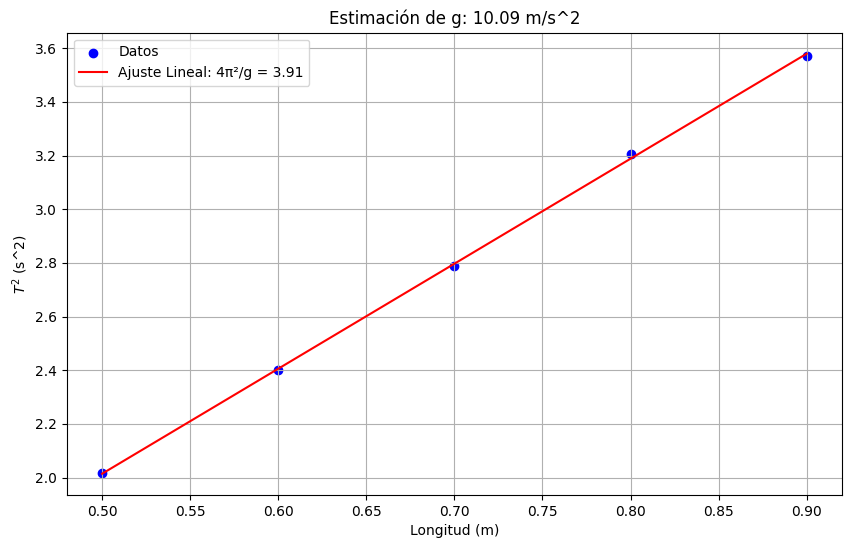

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

longitudes = [0.5, 0.6, 0.7, 0.8, 0.9]  # Ejemplo de longitudes en metros
periodos = [1.42, 1.55, 1.67, 1.79, 1.89]  # Ejemplo de periodos en segundos para las longitudes anteriores

# Definimos la función lineal para el ajuste
def linear_func(l, m, c):
    return m * l + c

# Cuadrado de los periodos
T_squared = np.square(periodos)

# Ajuste lineal
params, covariance = curve_fit(linear_func, longitudes, T_squared)
m, c = params

# Valores ajustados
T_squared_fit = linear_func(np.array(longitudes), m, c)

# Estimar g a partir de la pendiente
g_estimado = 4 * np.pi**2 / m

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(longitudes, T_squared, label='Datos', color='blue')
plt.plot(longitudes, T_squared_fit, label=f'Ajuste Lineal: 4π²/g = {m:.2f}', color='red')
plt.xlabel('Longitud (m)')
plt.ylabel('$T^2$ (s^2)')
plt.title(f'Estimación de g: {g_estimado:.2f} m/s^2')
plt.legend()
plt.grid(True)
plt.show()
